In [1]:
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [2]:
from mwasis import *  # noqa: F403

## Wprowadzenie

$$
  \alert{\underbrace{\color{black}P(\theta|D)}_
    {\text{pr. a posteriori}}}  {=}
  \frac{\alert{\overbrace{\color{black}P(D|\theta)}^
      {\text{wiarygodność}}}
  {\times}
  \alert{\overbrace{\color{black}P(\theta)}^
    {\text{pr. a priori}}}}{\alert{\underbrace{\color{black}\int_{\Theta}P(D|\theta^*)f(\theta^*)d\theta^*}_
        {\text{dane}}}}
$$

\alert{Problem z całkowaniem}

### Rozwiązania

- Próbkowanie z rozkładu a posteriori bez normalizacji
- Optymalizacja

# Łańcuch Markowa

## Przypomnienie
- zbiór stanów
- Następny stan zależy tylko od obecnego
- \alert{Zbiór stanów może byc ciągły!}
 
 \begin{example}
\begin{equation}\label{eq:state_dynamics}
z_{t+1} = \mathbf F z_t+\varepsilon_t
\end{equation}
$\varepsilon_t \sim N(b,Q)$ to losowa wartość
\end{example}

## Kostka i moneta

\alert{Chcemy symulować rzut kostka przy pomocy monety}

### Cel
 Losowanie sześciu elementów z jednakowym prawdopodobieństwem

### Możliwości

Losowanie dwóch elementów z jednakowym prawdopodobieństwem

\alert{$\frac{1}{6}=0.001010101010101..._2$}

## Kostka i moneta- Markow
 <!-- start w lsowym stanie 1 lub dwa  -->
<!-- ![](kostka.pdf) -->


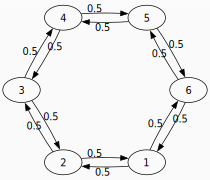

In [3]:
from graphviz import Source

# Store DOT code as a string
dot_code = '''
digraph Optimizers {
    layout="circo";
    bgcolor="#FAFAFA"; // Set background color
    node [fontname="Fira Sans"]; // Set font family for nodes
    edge [fontname="Fira Sans"]; // Set font family for edges
    size="5.3,2.5"; // Set the width and height (2.5 inch height)

    
    1->2 [ label = "0.5"];
    1->6 [ label = "0.5"];
    2->3 [ label = "0.5"];
    2->1 [ label = "0.5"];
    3->4 [ label = "0.5"];
    3->2 [ label = "0.5"];
    4->5 [ label = "0.5"];
    4->3 [ label = "0.5"];
    5->6 [ label = "0.5"];
    5->4 [ label = "0.5"];
    6->1 [ label = "0.5"];
    6->5 [ label = "0.5"];

}
'''
# Render the DOT code using graphviz's Source function
src = Source(dot_code)
src.render(view=False)  # Don't open an external viewer
src  # Display the graph in the notebook

## Kostka i moneta - Histogram

<!-- ![](kostka_hist.pdf) -->


I0000 00:00:1747868973.264935 7030726 service.cc:152] XLA service 0x160e4ce60 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747868973.264956 7030726 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1747868973.343573 7030726 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


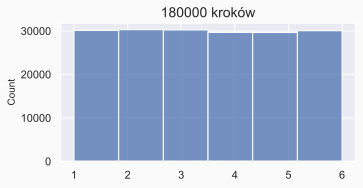

In [4]:


class SimulatedDie(tfp.mcmc.TransitionKernel):

  @property
  def is_calibrated(self):
    return True

  def one_step(self, current_state, previous_kernel_results):

    coin = tf.where(tf.random.normal(tf.shape(current_state))>0, -1., 1.)
    next_state = current_state + coin

    next_state = tf.where(next_state>6.,1.,next_state)
    next_state = tf.where(next_state<1.,6.,next_state)

    return next_state, previous_kernel_results

  def bootstrap_results(self, init_state):
    return 0.


@tf.function(jit_compile=True)
def sample():
  samples, _ = tfp.mcmc.sample_chain(
      num_results=180000,
      current_state=np.array(1., dtype=np.float32),
      kernel=SimulatedDie(),
      num_burnin_steps=20,
      trace_fn=lambda x,y:x)
  return samples


samples = sample();


sns.histplot(x=samples,bins=6, kde=False)
plt.title('180000 kroków');


## Kostka i moneta - autorelacja

<!-- ![](kostka_acf.pdf) -->


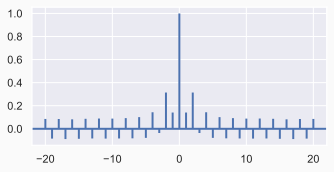

In [5]:
plt.acorr(samples-tf.reduce_mean(samples),maxlags=20);


## Kolejka jako sampler

### $M/M/1$ z intensywnością zależną od stanu

$$p_i\propto \frac{\lambda_0\lambda_1\cdots\lambda_{i-1}}{\mu_1\mu_2\cdots\mu_i}$$

\alert{Dobierając $\lambda_i$ oraz $\mu$ możemy symulować dowolny rozkład dyskretny symulując kolejkę}


# MCMC

1. Start w losowej konfiguracji
1. Losowa propozycja aktualizacji parametrów (losujemy ze znanego rozkładu)
1. Akceptujemy lub odrzucamy propozycję na podstawie dopasowania do danych i rozkładu a priori. 
1. 
    - Jeżeli akceptujemy propozycje to zmieniamy aktualną pozycję 
    - wracamy do 2
1. Po dużej liczbie iteracji zwracamy wszystkie zaakceptowane pozycje

\alert{Powinniśmy akceptowac ok 80\% propozycji}

## MCMC warianty

- Metropolis–Hastings-prosty, wolnobieżny \alert{dobry do dyskretnych parametrów}
- Gibbs sampler 
- Dynamika Hamiltonowska (HMC)- całkuje równania ruchu, problem z dopasowaniem parametrów
- **NUTS** (`tfp.mcmc.NoUTurnSampler`) polecany

## Metropolis–Hastings

Próbkowanie z $P(x)$ za pomocą pomocniczego rozkładu $g$

1. Losowy stan startowy $x$
1. Propozycja nastepnęgo stanu z rozkładu $x' \sim g$
1. Akcpetacja z pr $\displaystyle A(x'|x)=\min \left(1,{\frac {P(x')}{P(x)}}{\frac {g(x|x')}{g(x'|x)}}\right)$


## Diagnostyka

- Ułamek zaakceptowanych
    - Za duży: błądzenie
    - Za mały: Łańcuch nie eksploruje przestrzeni stanów
- Autokorelacja - jak mała to łańcuch dobrze próbkuje 
- $\hat R$ 
- effective sample size (ESS)

### Gelmana-Rubina ($\hat R$ )

Test zbieżności wykorzystujący $m$ niezależnych łańcuchów.
Porównujemy wariancję wewnątrz łańcucha z wariancją pomiędzy łańcuchami

\alert{Dobrze gdy $\hat R\approx 1$, źle, gdy $\hat R >> 1$}

`tfp.mcmc.potential_scale_reduction`


# Wnioskowanie wariacyjne

- Metoda przybliżona
- Wnioskowanie wariacyjne zamienia problem całkowania na problem optymalizacyjny
- Do szukania rozwiązania mona wykorzystać metody numeryczne do maksymalizacji wiarygodności

## Kroki

1. Wybieramy rodzinę rozkładów $\mathcal Q$ parametryzowaną przez parametr $t$ (moze być wiele parametrów)
1. Parametry dobieramy tak, aby zminimalizować odległość pomiędzy prawdziwym rozkładem a posteriori a rozkładem z naszej rodziny

$$q^*(\theta)=\arg\min_{q(\theta)\in \mathcal Q} KL(q(\theta)||p(\theta|D))$$

## Dywergencja Kullbacka-Leiblera

- Miara podobieństwa rozkładów
- \alert{To nie jest poprawna metryka} (symetria, trójkąt)

### Definicja

$$KL(q||p)=\int_Q q(x)\log\left(\frac{q(x)}{p(x)}\right) d x$$

### Aproksymacja

Wartość oczekiwana po $q$ z logarytmu ilorazu

$$KL(q||p)\approx \frac{1}{n}\sum_i\log\left(\frac{q(x_i)}{p(x_i)}\right), \quad x_i\sim q(x)$$

## evidence lower bound (ELBO)

\begin{align*}
ELBO(q)=E_q[\log p(\theta, D)]-E_q[\log q(\theta)]=\\=\underbrace{E_q[p(D|\theta)]}_{\text{\alert{wiarygodność}}}-\underbrace{KL(q(\theta)||p(\theta))}_{\text{\alert{kara}}}
\end{align*}


### ALgorytm

1. Losujemy parametry proponowanego rozkładu $q$
1. Liczymy średnią logarytmiczną funkcję wiarygodności
    - szczególny przypadek gdzie uśredniamy jedną obserwację
1. maksymalizujemy elbo

## Średnie Pole

### Rozkład wariacyjny

$$q(\mathbf \theta)=\prod_iq_i(\theta_i)$$

\begin{example}
Rodzina $\mathcal Q$ to zbiór rozkładów normalnych 

\alert{Na kady parametr mamy dwa nowe parametry: średnia i odchylenie standardowe rozkładu wariacyjnego}
\end{example}

## Podsumowanie

- Większość rozkładów a posteriori nie jest obliczalna analitycznie
- Łańcuch Markowa pozwala generować próbki z rozkładu a posteriori
- Wnioskowanie wariacyjne aproksymuje rozkład a posteriori znanymi rozkładami
- Oprogramowanie: TFP, Stan, pymc3


# {.standout}

Pytania